In [1]:
%pip install wheel

In [2]:
%pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Dataset

In [4]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [5]:
ds = tfds.load('uc_merced', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incompleteZYL9ZN/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()

{'filename': b'mediumresidential81.tif',
 'image': array([[[183, 193, 167],
         [182, 193, 169],
         [176, 186, 165],
         ...,
         [154, 162, 145],
         [162, 171, 146],
         [155, 171, 148]],
 
        [[138, 151, 134],
         [139, 152, 135],
         [132, 146, 131],
         ...,
         [185, 186, 179],
         [189, 191, 176],
         [188, 195, 177]],
 
        [[127, 144, 122],
         [130, 144, 122],
         [125, 144, 118],
         ...,
         [188, 189, 183],
         [193, 195, 184],
         [189, 193, 184]],
 
        ...,
 
        [[144, 154, 131],
         [156, 167, 139],
         [157, 166, 133],
         ...,
         [184, 188, 173],
         [192, 191, 175],
         [180, 192, 161]],
 
        [[145, 151, 125],
         [150, 152, 132],
         [153, 161, 133],
         ...,
         [175, 179, 168],
         [176, 173, 165],
         [153, 168, 148]],
 
        [[155, 164, 134],
         [157, 165, 137],
         [150, 160

In [7]:
import numpy as np

In [8]:
dataiterator = ds.as_numpy_iterator()

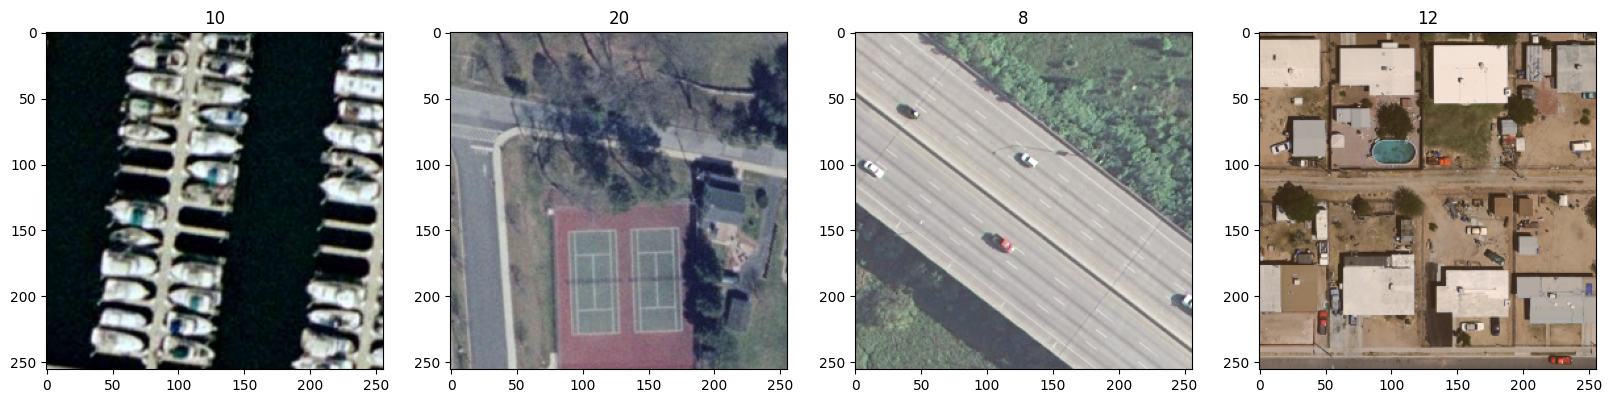

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    sample = dataiterator.next()
    ax[i].imshow(sample['image'])
    ax[i].set_title(sample['label'])


In [10]:
def scale(data):
    image = data['image']

    #resize to 256x256
    image = tf.image.resize(image, (256, 256))

    return image / 255

In [11]:
ds = tfds.load('uc_merced', split='train')

#preprocessing
ds = ds.map(scale)
ds = ds.cache()
ds = ds.shuffle(2100)
ds = ds.batch(16)
ds = ds.prefetch(16)

In [12]:
ds.as_numpy_iterator().next().shape

(16, 256, 256, 3)

## Generator

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Reshape, LeakyReLU, UpSampling2D

In [14]:
def build_generator():
  model = Sequential()

  model.add(Dense(8*8*16, input_dim=16))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 16)))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(16, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(16, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(16, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(16, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(16, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(16, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(16, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))


  model.add(Conv2D(3, kernel_size=3, padding='same', activation='sigmoid'))


  return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              17408     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 16)          0         
                                                                 
 up_sampling2d (UpSampling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        4112      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                        

In [25]:
img = generator.predict(np.random.randn(4,16, 1))


1/1 [==============================] - 0s 22ms/step


In [18]:
img.shape

(4, 256, 256, 3)

1/1 [==============================] - 0s 21ms/step


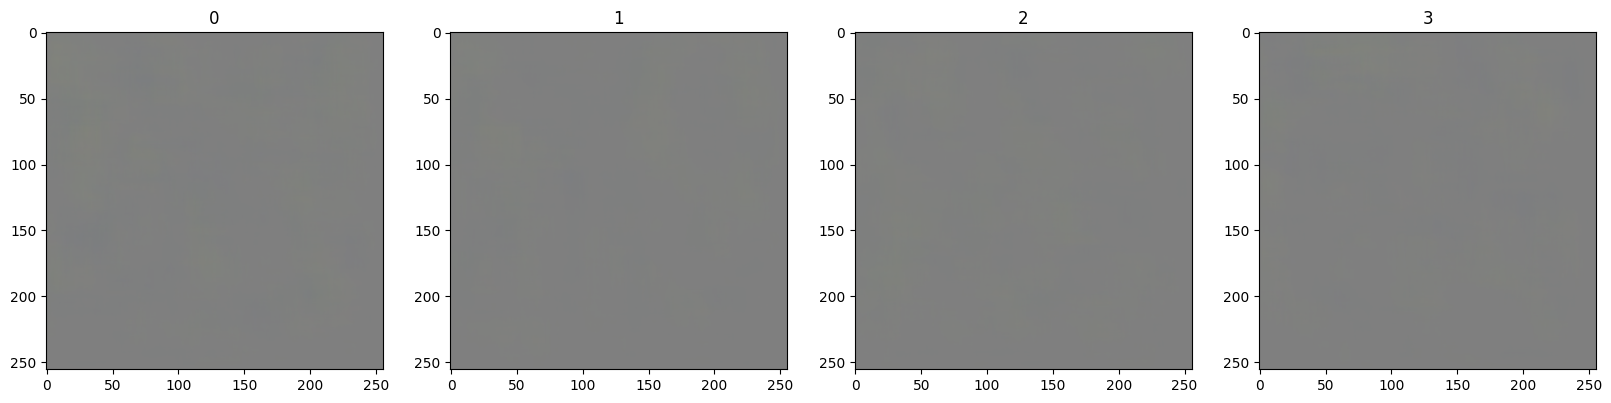

In [19]:
img = generator.predict(np.random.randn(4, 16, 1))
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for idx, img in enumerate(img):
    ax[idx].imshow(img)
    ax[idx].title.set_text(idx)

In [20]:
img.shape

(256, 256, 3)

## Discriminator

In [21]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, input_shape=(256, 256, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [22]:
discriminator = build_discriminator()

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 254, 254, 32)      0         
                                                                 
 dropout (Dropout)           (None, 254, 254, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 252, 252, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 252, 252, 64)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 250, 250, 128)    

In [26]:
discriminator.predict(img)

1/1 [==============================] - 2s 2s/step


array([[0.48872462],
       [0.48867318],
       [0.48867372],
       [0.48858035]], dtype=float32)

## Training Loop

In [27]:
from tensorflow.keras.losses import BinaryCrossentropy
# m1 mac optimization
from tensorflow.keras.optimizers.legacy import Adam

In [28]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
d_loss = BinaryCrossentropy()
g_loss = BinaryCrossentropy()

In [29]:
from tensorflow.keras.models import Model

In [30]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((16, 16, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((16,16,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [31]:
gan = GAN(generator, discriminator)

In [32]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [33]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [34]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=16):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [35]:
ds.as_numpy_iterator().next().shape

(16, 256, 256, 3)

In [37]:
hist = gan.fit(ds, epochs=300, callbacks=[ModelMonitor()])

Epoch 1/300
  6/132 [>.............................] - ETA: 24s - d_loss: 0.6422 - g_loss: 3.4661

132/132 [==============================] - 26s 195ms/step - d_loss: 0.5427 - g_loss: 3.6443
Epoch 2/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.2877 - g_loss: 2.4374
Epoch 3/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.2801 - g_loss: 2.4696
Epoch 4/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.3229 - g_loss: 1.9809
Epoch 5/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.2899 - g_loss: 2.3493
Epoch 6/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.2851 - g_loss: 2.4943
Epoch 7/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.4310 - g_loss: 1.7060
Epoch 8/300
132/132 [==============================] - 26s 195ms/step - d_loss: 0.8580 - g_loss: 3.5473
Epoch 9/300
132/132 [==============================] - 26s 196ms/step - d_loss: 0.6396 - g_loss: 1.0660
Epoch 10/300
132/132 [==============================] - 26s 195ms/step - d_l

In [1]:
plt.suptitle('Losses')
plt.plot(hist.history['d_loss'], label='Discriminator')
plt.plot(hist.history['g_loss'], label='Generator')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))


In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(imgs[i*4+j])